<p align="center">
  <br/>
    <a href="https://stabrise.com/scaledp/"><img alt="ScaleDP" src="https://raw.githubusercontent.com/StabRise/ScaleDP/refs/heads/master/images/scaledp.webp" width="376" style="max-width: 100%;"></a>
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/5.WithSparkPdf.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

# Benefits of useing Spark PDF Data Source with ScaleDP

- Effective reading big pdf files
- Lazy read per page
- No need to install Tesseract for run OCR

Related posts:

- [Structured Data Extraction from PDFs with AI](https://stabrise.com/blog/scaledp-with-spark-pdf/)


## Installation

In [ ]:
!pip install scaledp[ml]

## Start Spark Session with ScaleDP and Spark PDF Data Source

In [2]:
from scaledp import *

spark = ScaleDPSession(with_spark_pdf=True)
spark

## Read PDF file to the DataFrame

In [4]:
pdf_example = files('resources/pdfs/Invoice.pdf')

df = spark.read.format("pdf") \
    .load(pdf_example)

df.show()

Estimating resolution as 349                                        (0 + 1) / 1]


+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+
|                path|   filename|page_number|partition_number|  text|               image|            document|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+
|file:///Users/olc...|Invoice.pdf|          0|               0| \n \n|{file:///Users/ol...|{file:///Users/ol...|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+



## Show Image

Image#:,0
Path:,Invoice.pdf
Size:,0 x 0 px
Resolution:,300 dpi

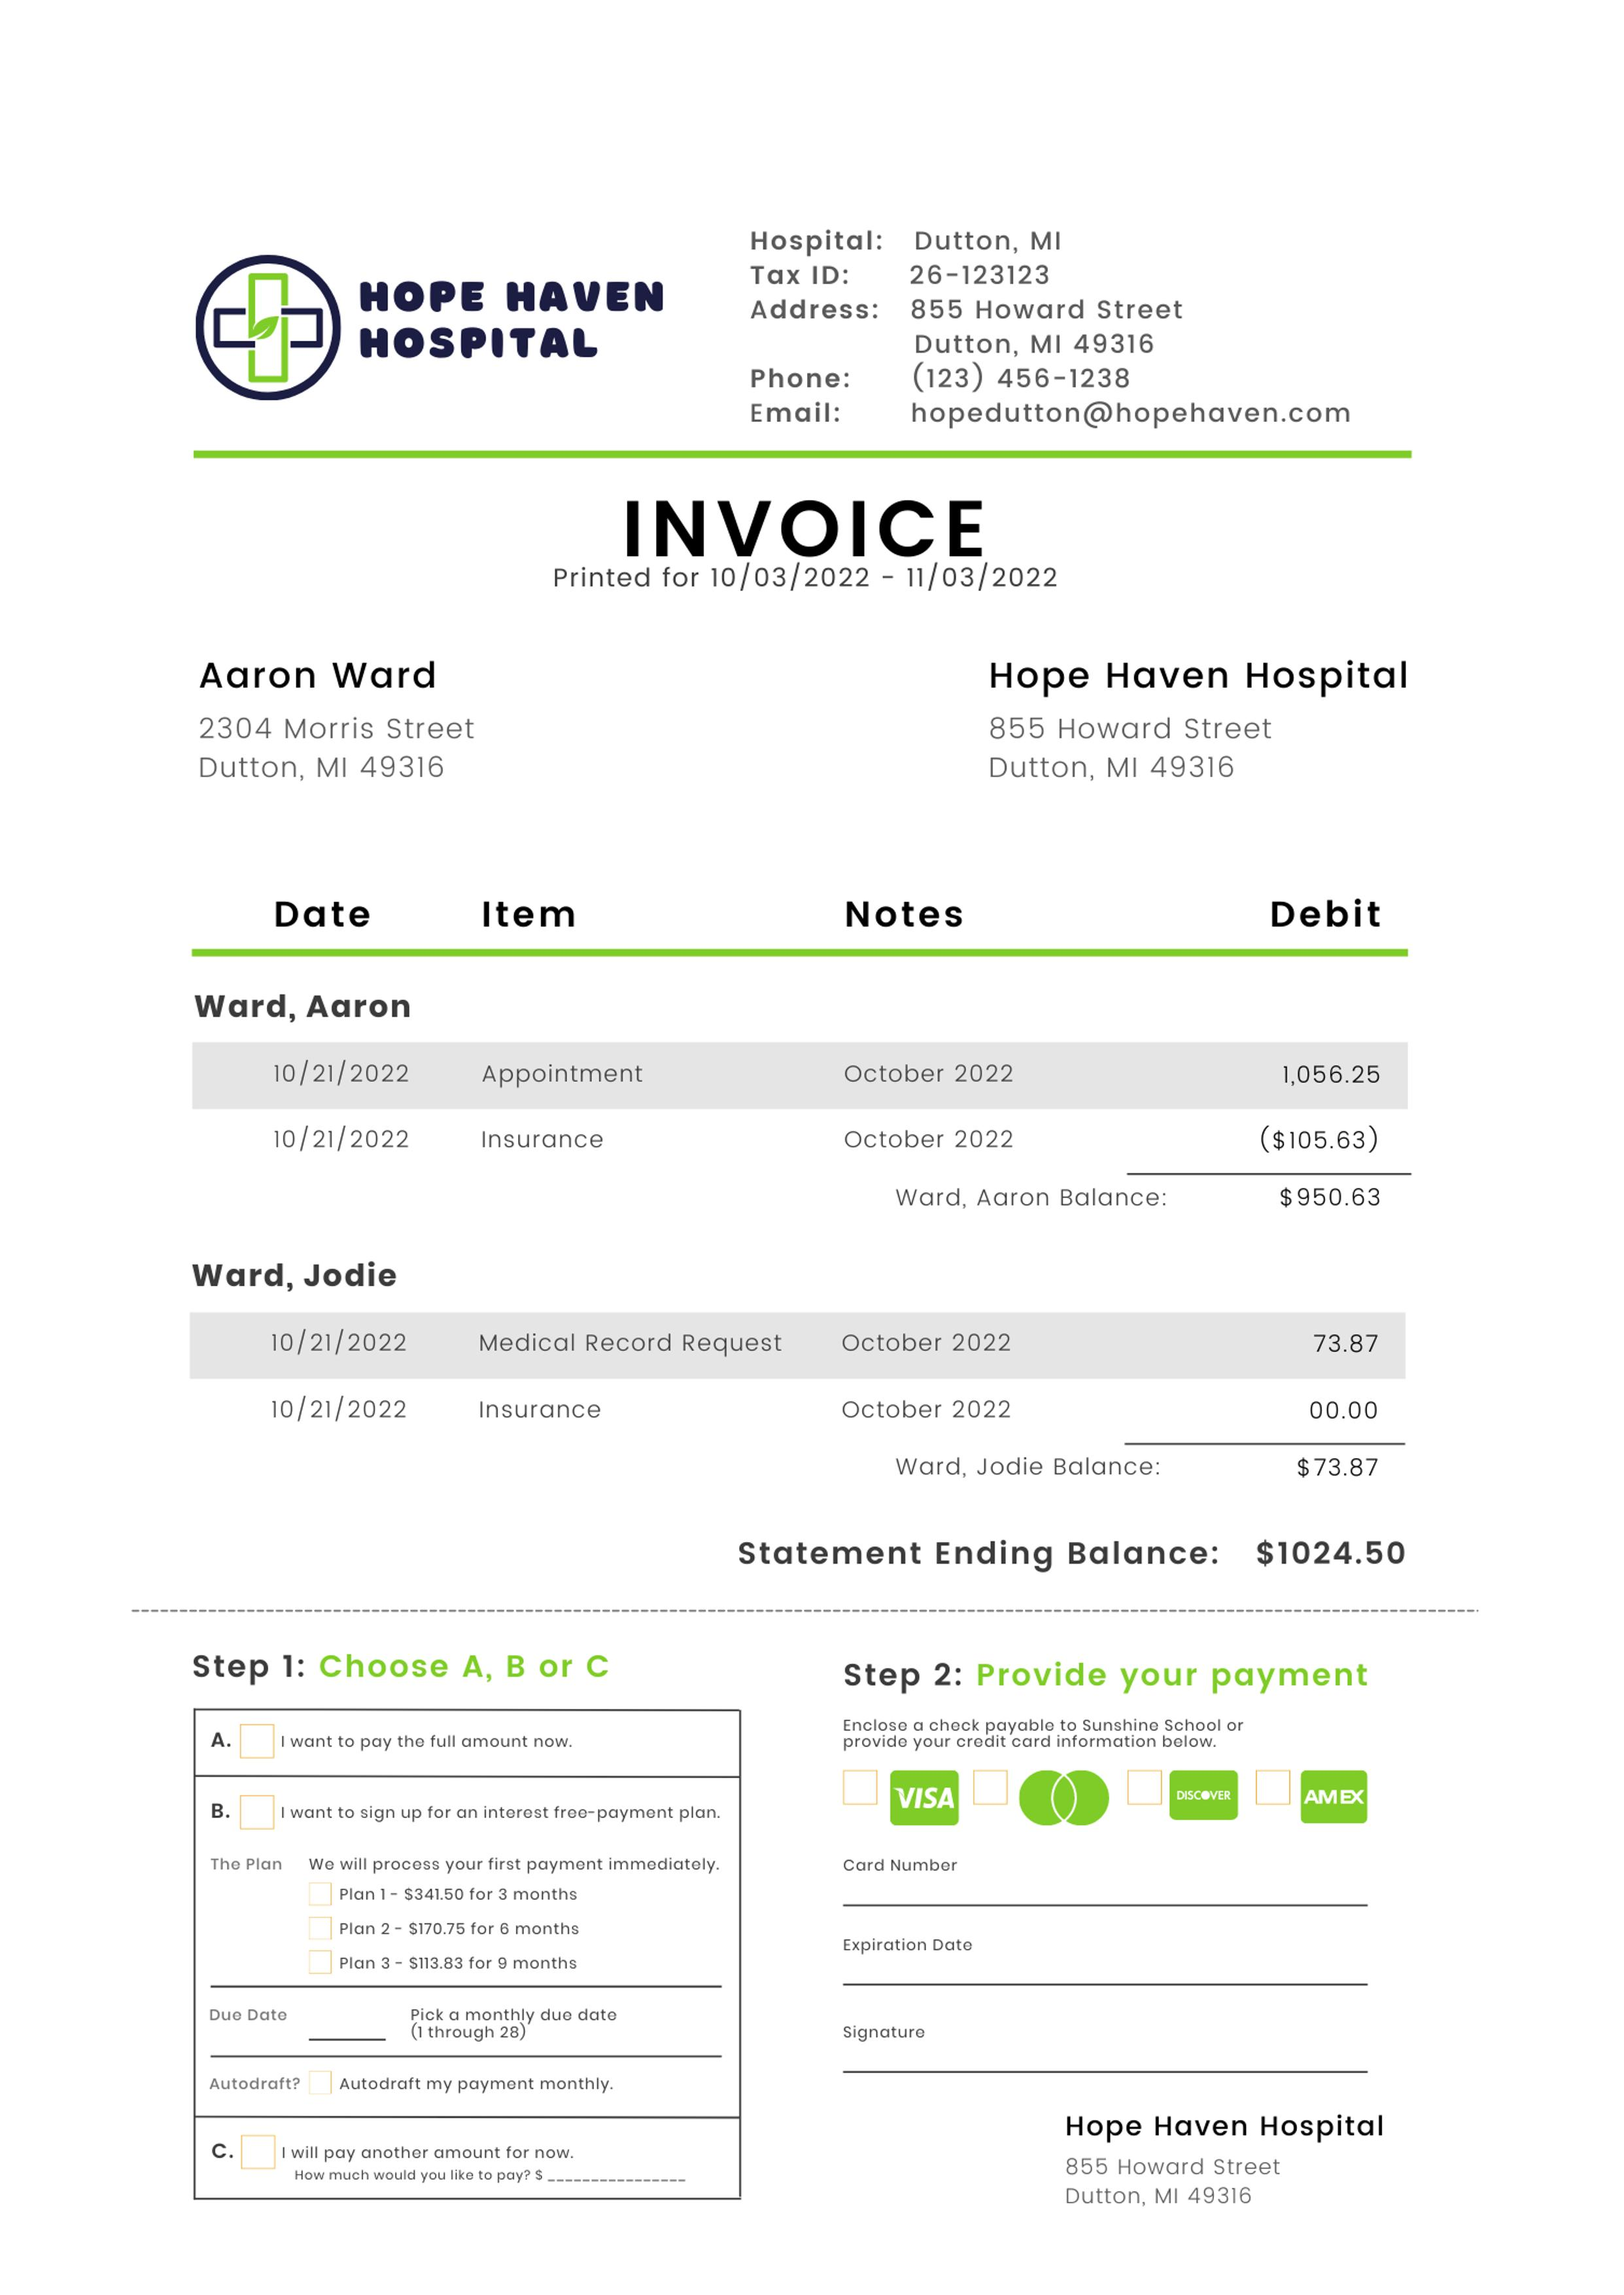

In [5]:
df.show_image()

## Show Text

In [4]:
df.show_text()

Estimating resolution as 349                                        (0 + 1) / 1]
                                                                                

Id:,0
Path:,Invoice.pdf


## More options of PDF Data Source

In [5]:
df = spark.read.format("pdf") \
    .option("imageType", "BINARY") \
    .option("resolution", "300") \
    .option("pagePerPartition", "2") \
    .option("reader", "pdfBox") \
    .option("ocrConfig", "psm=11") \
    .load(pdf_example)

df.show()

Estimating resolution as 349                                        (0 + 1) / 1]


+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+
|                path|   filename|page_number|partition_number|  text|               image|            document|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+
|file:///Users/olc...|Invoice.pdf|          0|               0| \n \n|{file:///Users/ol...|{file:///Users/ol...|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+



## Zero-Shot data Extraction from the Image extracted from PDF

For run this example you need get free API key for gemini here: [https://aistudio.google.com/apikey](https://aistudio.google.com/apikey)

Or use another LLM provider which provide multimadal model.

NOTE: LLMVisualExtractor supports OpenAI compatable API, so please set right `apiBase` parameter and `model`.

In [6]:
from pydantic import BaseModel, Field

class Items(BaseModel):
    date: str
    item: str
    note: str
    debit: str

class InvoiceSchema(BaseModel):
    hospital: str
    tax_id: str
    address: str
    email: str
    phone: str
    items: list[Items]
    total: str
    date_period: str
    

pipeline = PipelineModel(stages=[
    LLMVisualExtractor(
        model="gemini-1.5-flash",
        apiKey="",
        apiBase="https://generativelanguage.googleapis.com/v1beta/",
        schema=InvoiceSchema
    )
])

result = pipeline.transform(df).cache()

## Show extracted Json

In [7]:
result.show_json()

Estimating resolution as 349                                        (0 + 1) / 1]
                                                                                

Id:,0
Path:,Invoice.pdf


## Show results Data Frame

In [8]:
result.show()

+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+--------------------+
|                path|   filename|page_number|partition_number|  text|               image|            document|                data|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+--------------------+
|file:///Users/olc...|Invoice.pdf|          0|               0| \n \n|{file:///Users/ol...|{file:///Users/ol...|{file:///Users/ol...|
+--------------------+-----------+-----------+----------------+------+--------------------+--------------------+--------------------+



In [9]:
result.printSchema()

root
 |-- path: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- page_number: integer (nullable = true)
 |-- partition_number: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- resolution: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |    |-- imageType: string (nullable = true)
 |    |-- exception: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |-- document: struct (nullable = true)
 |    |-- path: string (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- outputType: string (nullable = true)
 |    |-- bBoxes: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |    |    |-- score: float (nullable = true)
 |    |    |    |-- x: integer (nullable = true)
 |    |    |    |-- y: intege

## Let's show Invoice as Structured Data in Data Frame

In [10]:
result.select("data.data.*").show()

+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+--------------------+
|           hospital|   tax_id|             address|               email|         phone|               items|  total|         date_period|
+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+--------------------+
|Hope Haven Hospital|26-123123|855 Howard Street...|hopedutton@hopeha...|(123) 456-1238|[{10/21/2022, App...|1024.50|10/03/2022 - 11/0...|
+-------------------+---------+--------------------+--------------------+--------------+--------------------+-------+--------------------+

